# Import packages and load datasets

In [120]:
import glob, os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model, ensemble
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

import time

# Warnings of system
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Dataset original
# df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('../dist/', "*.csv"))))
df = pd.read_csv('../dist/df_subset.csv')

In [3]:
# Datas
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S.%f')
df['year'] = [data.year for data in df['time']]
df['month'] = [data.month for data in df['time']]
df['day'] = [data.day for data in df['time']]
df['hour'] = [data.hour for data in df['time']]

# Dataset secundário
df_v2 = df[df.columns[1:]]

# Functions & Variables

In [51]:
modelos = [
    # linear_model
    linear_model.LinearRegression,
    linear_model.BayesianRidge,
    linear_model.HuberRegressor,
    linear_model.Lasso,
    linear_model.PassiveAggressiveRegressor,
    linear_model.RANSACRegressor,
    linear_model.Ridge,
    linear_model.SGDRegressor,
    
    # ensemble
    ensemble.AdaBoostRegressor,
    ensemble.BaggingRegressor,
    ensemble.ExtraTreesRegressor,
    ensemble.GradientBoostingRegressor,
    ensemble.RandomForestRegressor
]

# Exploratory data analysis (EDA)

In [5]:
# Teste para colunas vazias
df_na = df[[column for column in df if df[column].count() / len(df) >= 0.99]]

In [6]:
if pd.Series.tolist(df.columns) == pd.Series.tolist(df_na.columns):
    print("base sem null's! =)")
else:
    print("base com null's! =(")

base sem null's! =)


In [7]:
# Infos do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
time        100000 non-null datetime64[ns]
ca          100000 non-null object
unit        100000 non-null object
scp         100000 non-null object
station     99828 non-null object
linename    99828 non-null object
division    99828 non-null object
desc        100000 non-null object
entries     100000 non-null float64
exits       100000 non-null float64
year        100000 non-null int64
month       100000 non-null int64
day         100000 non-null int64
hour        100000 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(7)
memory usage: 10.7+ MB


In [8]:
# Descrição das features númericas do dataset
df.describe()

entries         exits      year     month            day  \
count  1.000000e+05  1.000000e+05  100000.0  100000.0  100000.000000   
mean   2.927970e+06  2.443422e+06    2010.0       4.0      18.298880   
std    3.096347e+06  6.509806e+06       0.0       0.0       0.987188   
min    0.000000e+00 -1.447243e+08    2010.0       4.0      17.000000   
25%    5.441925e+05  3.230530e+05    2010.0       4.0      17.000000   
50%    2.160288e+06  1.481380e+06    2010.0       4.0      18.000000   
75%    4.056736e+06  3.076883e+06    2010.0       4.0      19.000000   
max    3.156438e+07  3.303235e+08    2010.0       4.0      20.000000   

               hour  
count  100000.00000  
mean       10.24946  
std         6.64623  
min         0.00000  
25%         5.00000  
50%         9.00000  
75%        16.00000  
max        23.00000

In [9]:
# Leitura do cabeçalho
df.head()

time    ca  unit       scp        station linename division  \
0 2010-04-17 04:00:00  A002  R051  02-00-00  LEXINGTON AVE   456NQR      BMT   
1 2010-04-17 04:00:00  A002  R051  02-00-01  LEXINGTON AVE   456NQR      BMT   
2 2010-04-17 04:00:00  A002  R051  02-03-00  LEXINGTON AVE   456NQR      BMT   
3 2010-04-17 04:00:00  A002  R051  02-03-01  LEXINGTON AVE   456NQR      BMT   
4 2010-04-17 04:00:00  A002  R051  02-03-02  LEXINGTON AVE   456NQR      BMT   

      desc    entries      exits  year  month  day  hour  
0  REGULAR  2704717.0   928793.0  2010      4   17     4  
1  REGULAR  2697632.0   566683.0  2010      4   17     4  
2  REGULAR  1127722.0  3943492.0  2010      4   17     4  
3  REGULAR  2425570.0  3733289.0  2010      4   17     4  
4  REGULAR  2214633.0  3021589.0  2010      4   17     4

### Boxplot

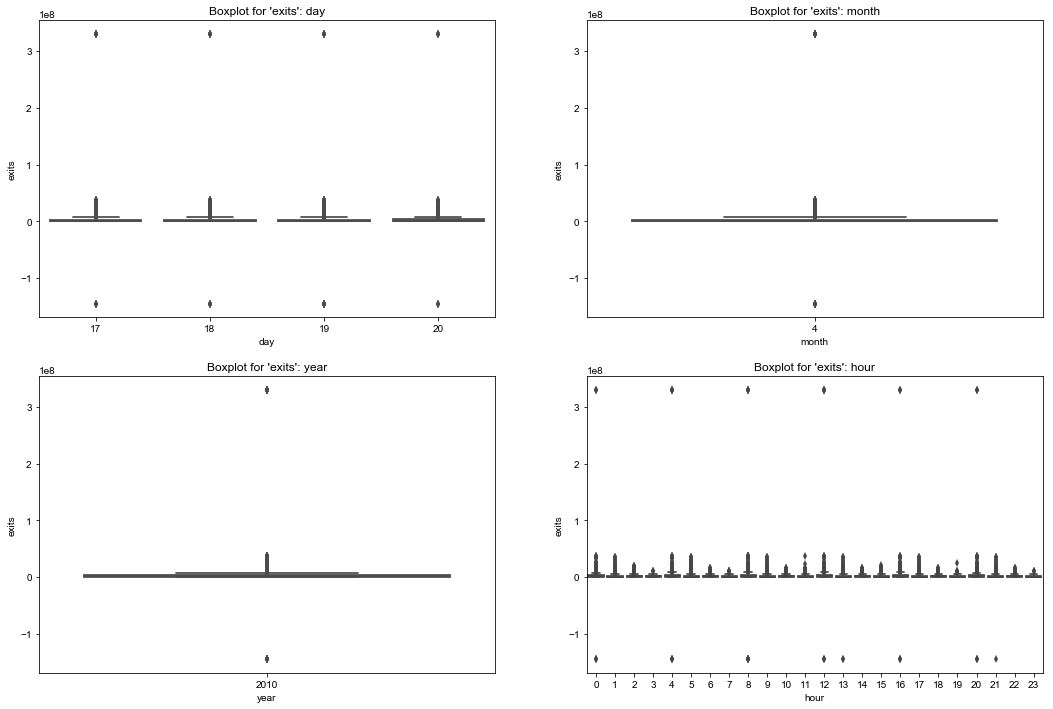

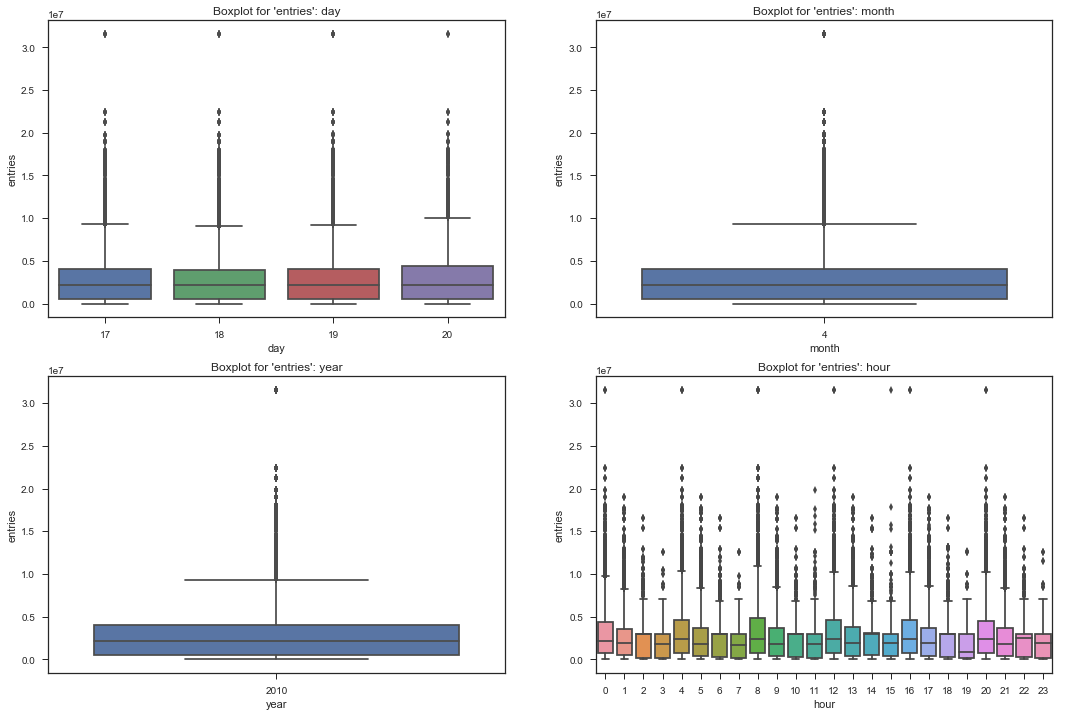

In [10]:
x_list = ['day','month','year','hour']
y_list = ['exits','entries']

for y in y_list:
    fig, ax = plt.subplots(int(len(x_list)/2), 2, figsize = (18, 12))

    for i, ax in enumerate(fig.axes):
        sns.set(style="ticks", palette="deep")
        sns.boxplot(
            x=x_list[i], 
            y=y,
            data=df,
            ax=ax
        ).set_title("Boxplot for '"+y+"': "+x_list[i])

### Convert features to Categorical

In [11]:
# Conversão de object para númerico
for cat_feature in df_v2.select_dtypes(include=['object']).columns:
    df_v2[cat_feature] = pd.Categorical(df_v2[cat_feature]).codes

In [12]:
df_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
ca          100000 non-null int16
unit        100000 non-null int16
scp         100000 non-null int16
station     100000 non-null int16
linename    100000 non-null int8
division    100000 non-null int8
desc        100000 non-null int8
entries     100000 non-null float64
exits       100000 non-null float64
year        100000 non-null int64
month       100000 non-null int64
day         100000 non-null int64
hour        100000 non-null int64
dtypes: float64(2), int16(4), int64(4), int8(3)
memory usage: 5.6 MB


In [13]:
# Resumo de cada feature
for coluna in df_v2.columns:
    print(df_v2[coluna].describe())
    print('\n\n')

count    100000.000000
mean        362.326550
std         197.121603
min           0.000000
25%         223.000000
50%         364.000000
75%         525.000000
max         720.000000
Name: ca, dtype: float64



count    100000.000000
mean        174.634260
std         142.077354
min           0.000000
25%          41.000000
50%         141.000000
75%         280.000000
max         461.000000
Name: unit, dtype: float64



count    100000.000000
mean         48.758480
std          48.020388
min           0.000000
25%           2.000000
50%          45.000000
75%          94.000000
max         203.000000
Name: scp, dtype: float64



count    100000.000000
mean        193.772200
std         120.091579
min          -1.000000
25%          79.000000
50%         187.000000
75%         304.000000
max         376.000000
Name: station, dtype: float64



count    100000.000000
mean         42.176910
std          32.876931
min          -1.000000
25%          14.000000
50%          32.000000
75%   

### Histogram

In [14]:
df_hist = df_v2.sort_index(axis=1)

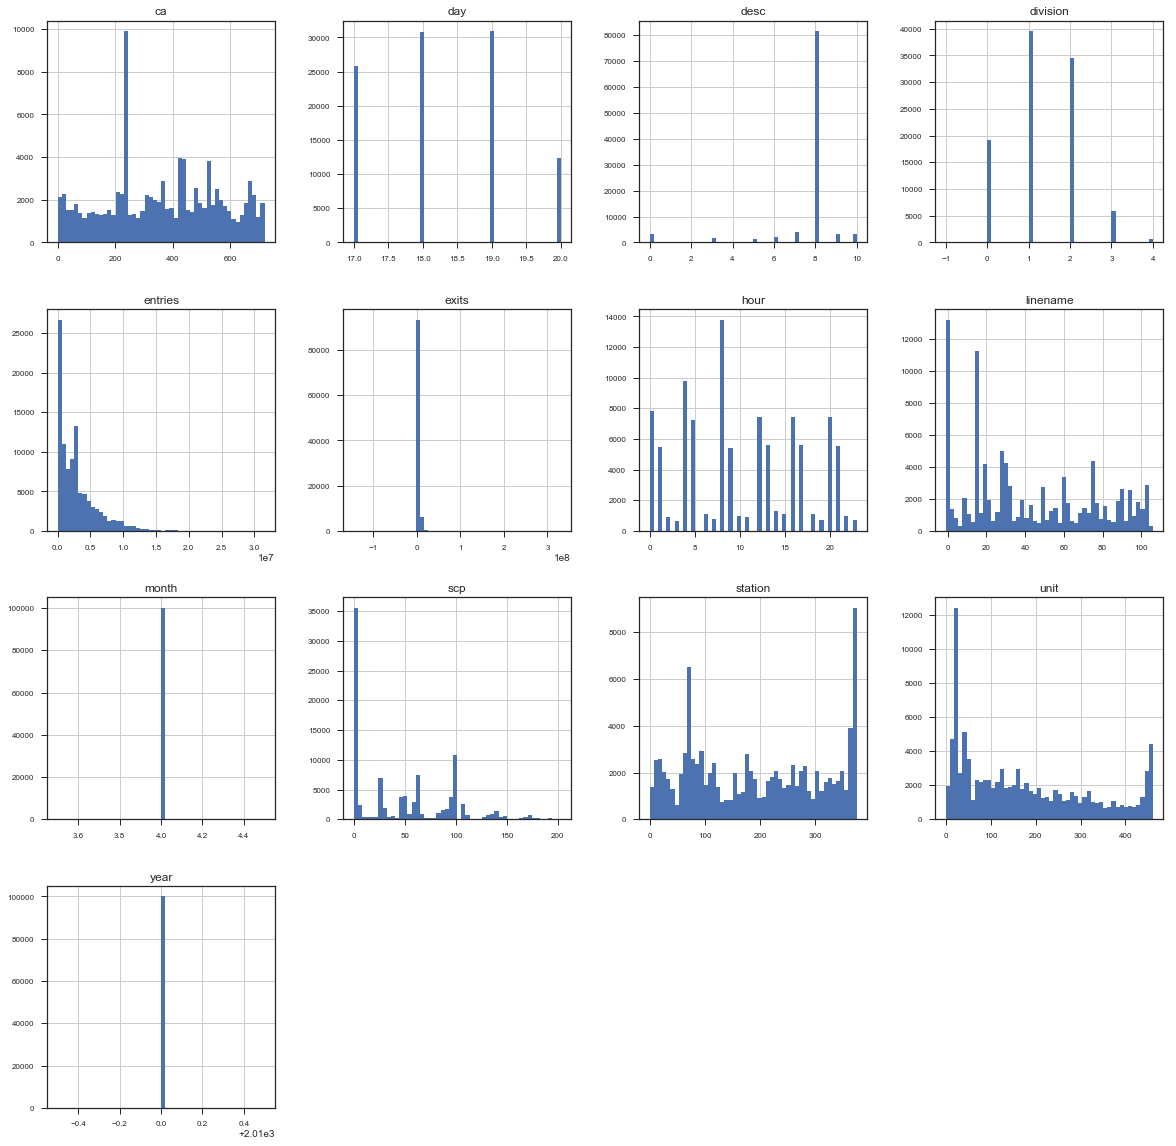

In [15]:
df_hist.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8);

### Correlation

<Figure size 792x648 with 0 Axes>

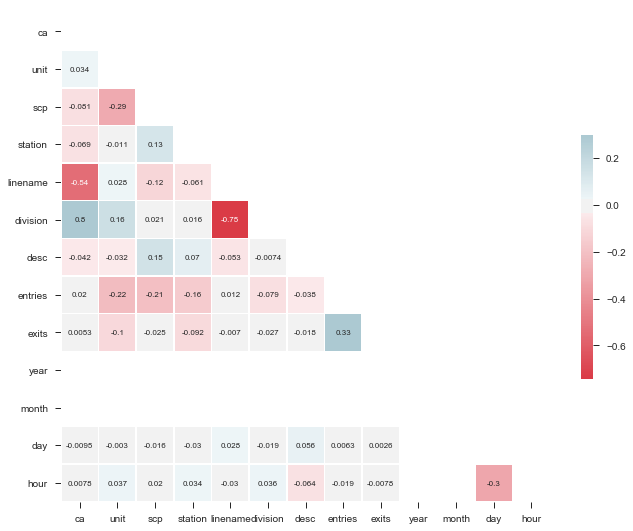

In [16]:
corr = df_v2.corr()
plt.figure(figsize=(11, 9))

# Mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Figure
f, ax = plt.subplots(figsize=(11, 9))

# Colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr, 
            cmap=cmap, 
            mask=mask,
            vmax=.3,             
            linewidths=.5,
            center=0,
            annot=True, 
            annot_kws={"size": 8}, 
            square=True, 
            cbar_kws={"shrink": .5});

In [17]:
# Tabela de correlação
corr

ca      unit       scp   station  linename  division  \
ca        1.000000  0.034274 -0.081013 -0.069011 -0.539930  0.803471   
unit      0.034274  1.000000 -0.287051 -0.011300  0.028476  0.163565   
scp      -0.081013 -0.287051  1.000000  0.129826 -0.115728  0.020564   
station  -0.069011 -0.011300  0.129826  1.000000 -0.061003  0.015748   
linename -0.539930  0.028476 -0.115728 -0.061003  1.000000 -0.745493   
division  0.803471  0.163565  0.020564  0.015748 -0.745493  1.000000   
desc     -0.042250 -0.031823  0.148229  0.069951 -0.053001 -0.007390   
entries   0.020078 -0.215252 -0.206080 -0.157150  0.011828 -0.078672   
exits     0.005333 -0.102479 -0.025448 -0.092233 -0.006990 -0.026748   
year           NaN       NaN       NaN       NaN       NaN       NaN   
month          NaN       NaN       NaN       NaN       NaN       NaN   
day      -0.009457 -0.003030 -0.016295 -0.030356  0.028440 -0.019098   
hour      0.007804  0.037323  0.019754  0.033733 -0.030272  0.035805   

              desc   entries     exits  year  month       day      hour  
ca       -0.042250  0.020078  0.005333   NaN    NaN -0.009457  0.007804  
unit     -0.031823 -0.215252 -0.102479   NaN    NaN -0.003030  0.037323  
scp       0.148229 -0.206080 -0.025448   NaN    NaN -0.016295  0.019754  
station   0.069951 -0.157150 -0.092233   NaN    NaN -0.030356  0.033733  
linename -0.053001  0.011828 -0.006990   NaN    NaN  0.028440 -0.030272  
division -0.007390 -0.078672 -0.026748   NaN    NaN -0.019098  0.035805  
desc      1.000000 -0.038479 -0.017832   NaN    NaN  0.056075 -0.064223  
entries  -0.038479  1.000000  0.328933   NaN    NaN  0.006281 -0.018547  
exits    -0.017832  0.328933  1.000000   NaN    NaN  0.002615 -0.007805  
year           NaN       NaN       NaN   NaN    NaN       NaN       NaN  
month          NaN       NaN       NaN   NaN    NaN       NaN       NaN  
day       0.056075  0.006281  0.002615   NaN    NaN  1.000000 -0.304921  
hour     -0.064223 -0.018547 -0.007805   NaN    NaN -0.304921  1.000000

### Linear Regression - entries/exits  vs feature

In [18]:
# df_v3 = df_v2
# y_list = ['entries','exits']

# for y in y_list:
#     fig, ax = plt.subplots(round(len(df_v3.columns) / 3), 3, figsize = (20, 20))

#     for i, ax in enumerate(fig.axes):
#         if i < len(df_v3.columns) - 1:        
#             sns.regplot(x=df_v3[df_v3.columns[i]],y=y, data=df_v3, ax=ax).set_title("LR for '"+y+"' vs "+df_v3.columns[i])

# Model Selection

In [19]:
# Dataset para model selection
df_ms = df_v2.copy()

# Predict Y
del df_ms['entries']
Y = df_v2['entries']

# List of results
resultados = [['status','model','mean','std','time']]

# Model selection - Score
for var in modelos:
    start = time.time()
    try:
        print(var)
        clf = var()
        scores = cross_val_score(clf, df_ms, Y, cv=10)
        print('Mean score: ',np.mean(scores), '/ Std Score: ',np.std(scores))
        resultados.append(['ok',var.__name__,np.mean(scores),np.std(scores),time.time() - start])
    except(Exception):
        print('>> Validar parâmetros.')
        resultados.append(['erro',var.__name__,None,None,time.time() - start])
        pass
    finally:            
        print('-'*100)

<class 'sklearn.linear_model.bayes.ARDRegression'>
>> Validar parâmetros.
----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model.base.LinearRegression'>
Mean score:  0.2236302212916912 / Std Score:  0.01037772255773992
----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model.bayes.BayesianRidge'>
Mean score:  0.10687809968441175 / Std Score:  0.01266969739984325
----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model.huber.HuberRegressor'>
Mean score:  -1.2940432931506294 / Std Score:  0.5641741249272697
----------------------------------------------------------------------------------------------------
<class 'sklearn.linear_model.coordinate_descent.Lasso'>
Mean score:  0.22363022419003914 / Std Score:  0.010377719414883338
-------------------------------------------

### Create XLS to results

In [77]:
writer = pd.ExcelWriter('resultados_modelos.xlsx', engine='xlsxwriter')

df_result = pd.DataFrame(resultados[1:])
df_result.columns = resultados[0]
df_result.to_excel(writer, sheet_name='Sheet1', index=False)
writer.save()

'ExtraTreesRegressor'

### Fit Model

In [145]:
# Seleciona o melhor modelo
df_result = df_result.sort_values(by='mean', ascending=False)
model_selected = pd.Series.tolist(df_result[:1]['model'])
# model_selected[0]

# Fit do modelo
# for item in modelos:
#     if str(item).find(model_selected[0]) > 0:
#         model_result = item.fit(X=df_ms,y=Y)

model_result = ensemble.GradientBoostingRegressor().fit(X=df_ms,y=Y)

In [160]:
# Ajuste para próximo ano
df_mp = df_ms.copy()
df_mp['year'] = df_mp['year']+1

df_mp['entries_new'] = list(map(int,model_result.predict(X=df_mp)))
df_mp['entries'] = df_v2['entries']

print('accuracy_score:\nnormalize_true = {:f} \nnormalize_false = {:f}'.format(
    accuracy_score(df_mp['entries_new'], df_mp['entries']),
    accuracy_score(df_mp['entries_new'], df_mp['entries'], normalize=False)
    ))

SyntaxError: can't assign to function call (<ipython-input-160-480d43e8e088>, line 3)

In [159]:
df_mp

ca  unit  scp  station  linename  division  desc       exits  year  \
0        0    49  106      274        25         0     8    928793.0  2011   
1        0    49  107      274        25         0     8    566683.0  2011   
2        0    49  129      274        25         0     8   3943492.0  2011   
3        0    49  130      274        25         0     8   3733289.0  2011   
4        0    49  131      274        25         0     8   3021589.0  2011   
5        0    49  132      274        25         0     8   2575465.0  2011   
6        0    49  133      274        25         0     8   1751238.0  2011   
7        0    49  134      274        25         0     8    907884.0  2011   
8        0    49  135      274        25         0     8    409266.0  2011   
9        0    49  137      274        25         0     8         0.0  2011   
10       0    49  138      274        25         0     8       242.0  2011   
11       0    49  140      274        25         0     8     87086.0  2011   
12       3    70    0       89        99         0     8    469521.0  2011   
13       3    70    1       89        99         0     8   3167269.0  2011   
14       3    70    2       89        99         0     8   2481915.0  2011   
15       3    70    3       89        99         0     8    118599.0  2011   
16       3    70    4       89        99         0     8    381666.0  2011   
17       3    70    5       89        99         0     8   2840633.0  2011   
18       3    70    6       89        99         0     8   3226745.0  2011   
19       3    70    7       89        99         0     8   3801851.0  2011   
20       4    70   60       89        99         0     8  10444513.0  2011   
21       4    70   61       89        99         0     8   4778644.0  2011   
22       4    70   62       89        99         0     8   3351479.0  2011   
23       4    70   63       89        99         0     8   4354543.0  2011   
24       4    70   64       89        99         0     8   6619520.0  2011   
25       4    70   65       89        99         0     8   7549717.0  2011   
26       5    71   60       79        99         0     8  22745808.0  2011   
27       5    71   85       79        99         0     8    554836.0  2011   
28       5    71   86       79        99         0     8    471290.0  2011   
29       5    71   87       79        99         0     8   1825995.0  2011   
...    ...   ...  ...      ...       ...       ...   ...         ...   ...   
99970  662   250   26       70        29         2     7   3747587.0  2011   
99971  662   250   27       70        29         2     5   3020756.0  2011   
99972  662   250   28       70        29         2     8   4894242.0  2011   
99973  663   212    0       77        29         2     8   2225223.0  2011   
99974  663   212    0       77        29         2     8   2225223.0  2011   
99975  663   212    1       77        29         2     8    379353.0  2011   
99976  663   212    1       77        29         2     8    379353.0  2011   
99977  663   212    2       77        29         2     8   3107919.0  2011   
99978  663   212    2       77        29         2     7   3107919.0  2011   
99979  663   212    3       77        29         2     8   4421567.0  2011   
99980  663   212    3       77        29         2     7   4421567.0  2011   
99981  663   212   26       77        29         2     8   4541279.0  2011   
99982  663   212   26       77        29         2     7   4541279.0  2011   
99983  663   212   27       77        29         2     8   1796449.0  2011   
99984  663   212   27       77        29         2     7   1796449.0  2011   
99985  663   212   28       77        29         2     8    572589.0  2011   
99986  663   212   28       77        29         2     7    572589.0  2011   
99987  663   212   29       77        29         2     8   5541202.0  2011   
99988  663   212   29       77        29         2     7   5541202.0  2011   
99989  664   212   93       77